**Name Entity Extraction using Spacy, Bert and Custom Method**

https://thecleverprogrammer.com/2020/12/25/named-entity-recognition-with-python/

https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/



In [1]:
# IOB SCHEME
# I – Token is inside an entity.
# O – Token is outside an entity.
# B – Token is the beginning of an entity.

# BILUO SCHEME
# B – Token is the beginning of a multi-token entity.
# I – Token is inside a multi-token entity.
# L – Token is the last token of a multi-token entity.
# U – Token is a single-token unit entity.
# O – Toke is outside an entity.

In [2]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install transformers

     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 9.1MB 51.6MB/s 
     |████████████████████████████████| 460kB 54.3MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
     |████████████████████████████████| 122kB 56.6MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=f32f65acff277c7184b1784b6b195581c75c66201fdff53d3ba20e02ccf3622d
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: smart-open 4.2.0
    Uninstalling smart-open-4.2.0:
      Successfully uninstalled smart-open-4.2.0
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    U

In [3]:
import spacy
# Load English tokenizer, tagger, parser and NER
# nlp = spacy.load("en_core_web_sm")
from spacy import displacy
from spacy.util import minibatch, compounding
from pathlib import Path
import random
from tqdm import tqdm, trange
import numpy as np
# from spacy.training import Example

In [4]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')

tag2idx, idx2tag = get_dict_map(data, 'tag')
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [6]:
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[24394, 11562, 5083, 10087, 23240, 16972, 3029...","[15, 15, 15, 15, 15, 15, 11, 15, 15, 15, 15, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[15744, 26453, 6125, 30040, 9351, 34665, 17732...","[4, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[17020, 11847, 1698, 15639, 480, 8342, 34483, ...","[15, 15, 14, 15, 15, 15, 15, 15, 11, 15, 15, 1..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[22746, 34920, 869, 10714, 26713, 21881, 1656,...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[21497, 25512, 22381, 14538, 2538, 13730, 3325...","[11, 15, 15, 12, 8, 15, 14, 15, 11, 15, 4, 15,..."


In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [8]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [9]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


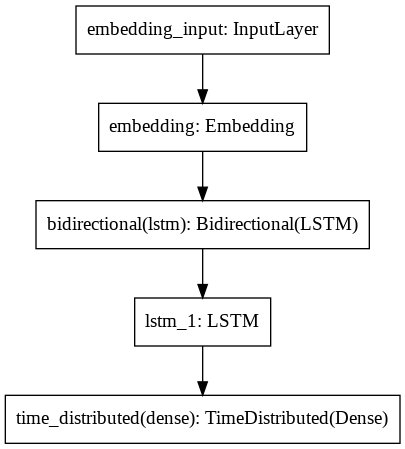

In [10]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [11]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

26/26 [==============================] - 30s 1s/step - loss: 0.0815 - accuracy: 0.9710 - val_loss: 0.0991 - val_accuracy: 0.9712


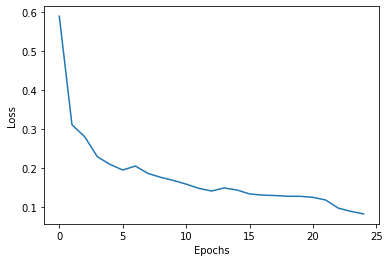

In [12]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [13]:
article_text="""India that previously comprised only a handful of players in the e-commerce space, is now home to many biggies and giants battling out with each other to reach the top. This is thanks to the overwhelming internet and smartphone penetration coupled with the ever-increasing digital adoption across the country. These new-age innovations not only gave emerging startups a unique platform to deliver seamless shopping experiences but also provided brick and mortar stores with a level-playing field to begin their online journeys without leaving their offline legacies.
In the wake of so many players coming together on one platform, the Indian e-commerce market is envisioned to reach USD 84 billion in 2021 from USD 24 billion in 2017. Further, with the rate at which internet penetration is increasing, we can expect more and more international retailers coming to India in addition to a large pool of new startups. This, in turn, will provide a major Philip to the organized retail market and boost its share from 12% in 2017 to 22-25% by 2021. 
Here’s a view to the e-commerce giants that are dominating India’s online shopping space:
Amazon – One of the uncontested global leaders, Amazon started its journey as a simple online bookstore that gradually expanded its reach to provide a large suite of diversified products including media, furniture, food, and electronics, among others. And now with the launch of Amazon Prime and Amazon Music Limited, it has taken customer experience to a godly level, which will remain undefeatable for a very long time. 
Flipkart – Founded in 2007, Flipkart is recognized as the national leader in the Indian e-commerce market. Just like Amazon, it started operating by selling books and then entered other categories such as electronics, fashion, and lifestyle, mobile phones, etc. And now that it has been acquired by Walmart, one of the largest leading platforms of e-commerce in the US, it has also raised its bar of customer offerings in all aspects and giving huge competition to Amazon. 
Snapdeal – Started as a daily deals platform in 2010, Snapdeal became a full-fledged online marketplace in 2011 comprising more than 3 lac sellers across India. The platform offers over 30 million products across 800+ diverse categories from over 125,000 regional, national, and international brands and retailers. The Indian e-commerce firm follows a robust strategy to stay at the forefront of innovation and deliver seamless customer offerings to its wide customer base. It has shown great potential for recovery in recent years despite losing Freecharge and Unicommerce. 
ShopClues – Another renowned name in the Indian e-commerce industry, ShopClues was founded in July 2011. It’s a Gurugram based company having a current valuation of INR 1.1 billion and is backed by prominent names including Nexus Venture Partners, Tiger Global, and Helion Ventures as its major investors. Presently, the platform comprises more than 5 lac sellers selling products in nine different categories such as computers, cameras, mobiles, etc. 
Paytm Mall – To compete with the existing e-commerce giants, Paytm, an online payment system has also launched its online marketplace – Paytm Mall, which offers a wide array of products ranging from men and women fashion to groceries and cosmetics, electronics and home products, and many more. The unique thing about this platform is that it serves as a medium for third parties to sell their products directly through the widely-known app – Paytm. 
Reliance Retail – Given Reliance Jio’s disruptive venture in the Indian telecom space along with a solid market presence of Reliance, it is no wonder that Reliance will soon be foraying into retail space. As of now, it has plans to build an e-commerce space that will be established on online-to-offline market program and aim to bring local merchants on board to help them boost their sales and compete with the existing industry leaders. 
Big Basket – India’s biggest online supermarket, Big Basket provides a wide variety of imported and gourmet products through two types of delivery services – express delivery and slotted delivery. It also offers pre-cut fruits along with a long list of beverages including fresh juices, cold drinks, hot teas, etc. Moreover, it not only provides farm-fresh products but also ensures that the farmer gets better prices. 
Grofers – One of the leading e-commerce players in the grocery segment, Grofers started its operations in 2013 and has reached overwhelming heights in the last 5 years. Its wide range of products includes atta, milk, oil, daily need products, vegetables, dairy products, juices, beverages, among others. With its growing reach across India, it has become one of the favorite supermarkets for Indian consumers who want to shop grocery items from the comforts of their homes. 
Digital Mall of Asia – Going live in 2020, Digital Mall of Asia is a very unique concept coined by the founders of Yokeasia Malls. It is designed to provide an immersive digital space equipped with multiple visual and sensory elements to sellers and shoppers. It will also give retailers exclusive rights to sell a particular product category or brand in their respective cities. What makes it unique is its zero-commission model enabling retailers to pay only a fixed amount of monthly rental instead of paying commissions. With its one-of-a-kind features, DMA is expected to bring
never-seen transformation to the current e-commerce ecosystem while addressing all the existing e-commerce worries such as counterfeiting. """


In [14]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Aman Kharwal \n I am from India \n I want to work with Google \n Steve Jobs is My Inspiration')
displacy.render(nlp(article_text), style = 'ent', jupyter=True)

## NER Using Bert

In [15]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands']

In [16]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O']


In [17]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.8.1+cu101'

In [19]:
MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla T4'

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [21]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

  
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [22]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]



In [23]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [24]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [25]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [26]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.cuda();



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [27]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [28]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [29]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=5b4e5344f9e1e03a2103ff587e06c1b19d16c712cc3f37362a9190a47b1e93f8
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [30]:
from seqeval.metrics import f1_score, accuracy_score

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    # print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.39235363603245776


Epoch:  33%|███▎      | 1/3 [09:58<19:57, 598.90s/it]

Validation loss: 0.3124113463920852
Validation Accuracy: 0.8991256476683938
Average train loss: 0.2553025854753539


Epoch:  67%|██████▋   | 2/3 [19:56<09:58, 598.59s/it]

Validation loss: 0.27177415086266893
Validation Accuracy: 0.9098121761658031
Average train loss: 0.2057603877124061


Epoch: 100%|██████████| 3/3 [29:52<00:00, 597.62s/it]

Validation loss: 0.28800992728210983
Validation Accuracy: 0.9114313471502591


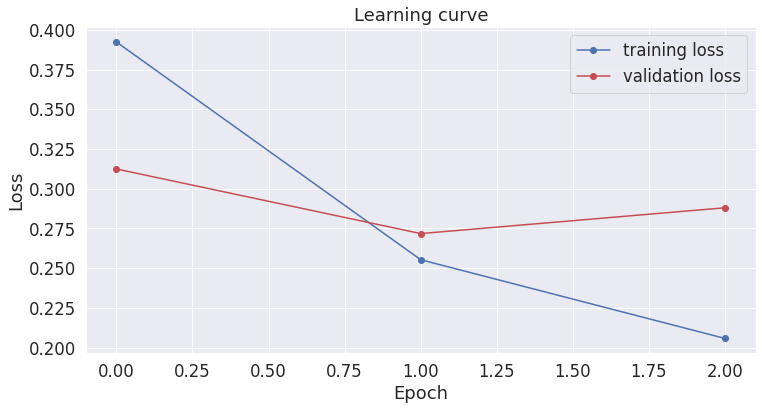

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [33]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))



B-org	[CLS]
O	Mr
B-org	.
B-org	Trump
B-org	’
B-org	s
O	tweets
B-org	began
B-org	just
B-org	moments
B-org	after
B-org	a
B-org	Fox
B-org	News
B-org	report
B-org	by
B-per	Mike
B-per	Tobin
B-org	,
B-org	a
B-org	reporter
B-org	for
B-org	the
B-org	network
B-org	,
O	about
B-org	protests
B-org	in
B-org	Minnesota
B-org	and
B-org	elsewhere
B-org	.
B-org	[SEP]


# Practice --- Custome NER using LSTM

https://valueml.com/named-entity-recognition-using-lstm-in-keras/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

Tensorflow version: 2.4.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [5]:
data = pd.read_csv("/content/sample_data/ner_soldier_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [7]:
print("Unique tags in corpus:", data['Tag'].unique())

Unique tags in corpus: ['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [10]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

print(num_words, num_tags)

35179 17


In [11]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [13]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx

{'belongs': 1,
 'Hurtado': 2,
 'sit': 3,
 'Doo-hwan': 4,
 'bullet': 5,
 'Rafat': 6,
 'permitted': 7,
 'anti-money-laundering': 8,
 'Splendid': 9,
 'Kuhn': 10,
 'originates': 11,
 'Milton': 12,
 'L.': 13,
 'classes': 14,
 'Thanh': 15,
 'taste': 16,
 'Justine': 17,
 'warships': 18,
 'Russia': 19,
 'supplements': 20,
 '1672': 21,
 'al-Hariri': 22,
 'Taro': 23,
 'Sebastien': 24,
 'Tayyeb': 25,
 'strained': 26,
 'Commemorations': 27,
 'provincial': 28,
 'embraces': 29,
 'Micky': 30,
 'Cincinnati': 31,
 'veal': 32,
 'good': 33,
 'breaking': 34,
 'bold': 35,
 'forefront': 36,
 'coasts': 37,
 '1890': 38,
 'wages': 39,
 'counter-proposal': 40,
 'deposed': 41,
 'hydrocarbon': 42,
 'Katrina': 43,
 'Sutham': 44,
 'Amazon': 45,
 'Basic': 46,
 '70s': 47,
 'burned': 48,
 'bullet-riddled': 49,
 'NEW': 50,
 'pictures': 51,
 'dove': 52,
 'long-condemned': 53,
 'ACCORD': 54,
 'schemes': 55,
 'Burkinabe': 56,
 'AGOA': 57,
 'Guest': 58,
 'Mueller': 59,
 "Shi'te": 60,
 'apply': 61,
 'followers': 62,
 'loose

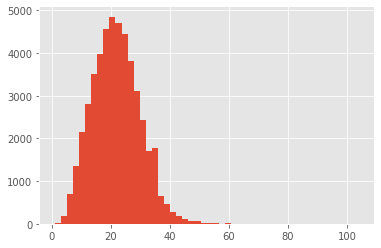

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

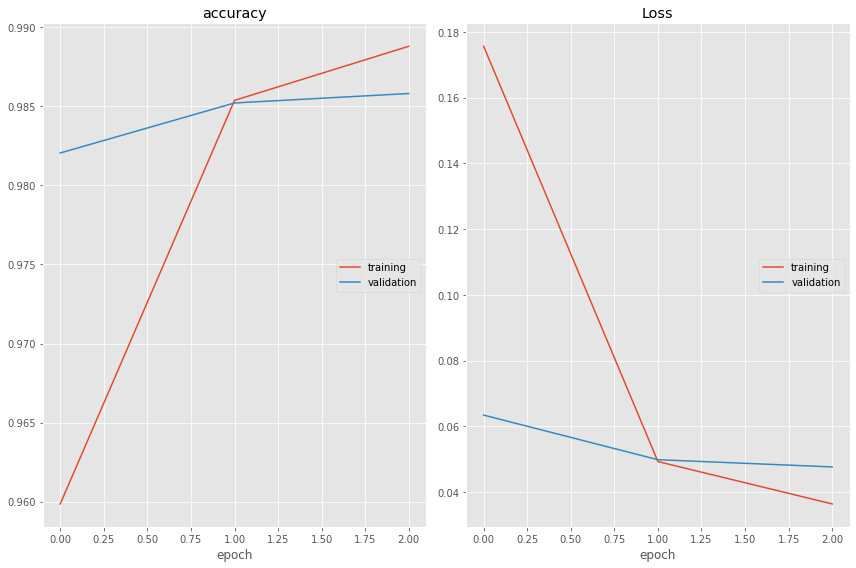

accuracy
	training         	 (min:    0.960, max:    0.989, cur:    0.989)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.176, cur:    0.036)
	validation       	 (min:    0.048, max:    0.063, cur:    0.048)

Epoch 00003: val_loss improved from 0.04982 to 0.04763, saving model to model_weights.h5


In [28]:
!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [29]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 7s 24ms/step - loss: 0.0476 - accuracy: 0.9858


[0.047627903521060944, 0.9858048558235168]

In [34]:
i = np.random.randint(0, x_test.shape[0]) #9592
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Earlier        O	O
this           O	O
week           O	O
,              O	O
prosecutors    O	O
sought         O	O
the            O	O
death          O	O
penalty        O	O
for            O	O
the            O	O
group          O	O
's             O	O
alleged        O	O
ringleader     O	O
Myuran         B-per	B-per
Sukumaran      I-per	I-per
.              O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov       O	O
Pleshkov     